In [1]:
import torch
from functools import partial
from torch import nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset,IterableDataset,Dataset
import lightning.pytorch as pl
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateFinder,LearningRateMonitor
from lightning.pytorch.callbacks import EarlyStopping,ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from scipy.ndimage import convolve1d
from collections import Counter
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from util.vani import *
import joblib
# from MODELS import cbam
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import yaml
from pytorch_lightning.loggers import TensorBoardLogger

c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Goal
Given a bunch of functions $$y=a_ix$$, let the neural network learn the coefficients $a_i$.

In [3]:
def func1(a,b,c,x):
    return a*np.sin(c*x)+b*np.sin(x)
def func2(a,b,c,x):
    return np.sin(a*np.sin(c*x)+b*np.sin(x))
def func3(a,x):
    return a*np.sin(x)
def func4(a,x):
    return np.sin(a*np.sin(x))
def func5(a,x):
    return a*x

In [10]:
np.random.seed(1992)
train_x=np.linspace(0,12,100)
train_x=np.reshape(train_x,(1,-1))
A=np.random.uniform(0,2,1000).T
B=np.random.uniform(0,2,1000).T
C=np.random.uniform(0.5,1,1000).T
list_func=[func5(A[i],train_x) for i in range(1000)]
list_func2=[func4(A[i],train_x) for i in range(1000)]
list_func=np.vstack(list_func)
list_func2=np.vstack(list_func2)
label=np.vstack([A])
# label

In [11]:
len(list_func)

1000

In [15]:
list_func_exp=np.vstack([train_x,list_func])
list_func_exp2=np.vstack([train_x,list_func2])

In [16]:
training_table=pd.DataFrame(list_func_exp.T)
training_table.rename(columns={0:'E'},inplace=True)
keys=list(training_table.keys())
for i in keys[1:]:
    training_table.rename(columns={i:i-1},inplace=True)
training_table.to_csv('dataset/training_table.csv',index=False)
test_table=pd.DataFrame(list_func_exp2.T)
test_table.rename(columns={0:'E'},inplace=True)
keys=list(test_table.keys())
for i in keys[1:]:
    test_table.rename(columns={i:i-1},inplace=True)
test_table.to_csv('dataset/test_table.csv',index=False)

In [18]:
training_label=pd.DataFrame(label.T,columns=['A']).T

training_label.to_csv('dataset/training_label.csv',index=True)
test_label=pd.DataFrame(label.T,columns=['A']).T
test_label.to_csv('dataset/test_label.csv',index=True)

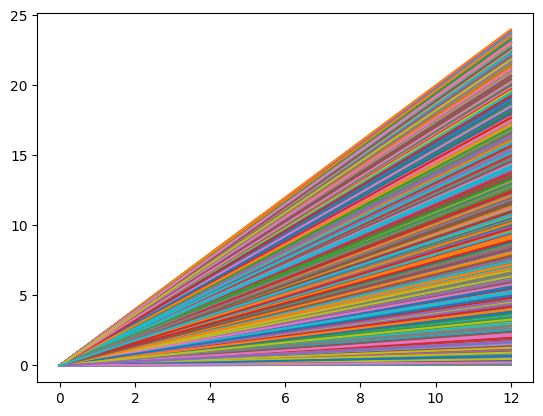

In [19]:
for i in range(1000):
    plt.plot(train_x[0],list_func[i])

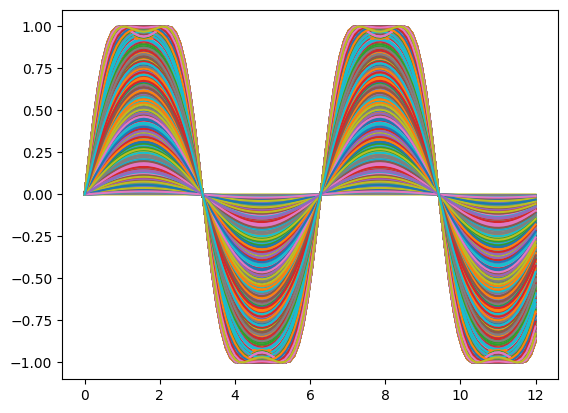

In [20]:
for i in range(1000):
    plt.plot(train_x[0],list_func2[i])

# vanila simple neural network

In [21]:
pd.read_csv('dataset/training_label.csv',index_col=0)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
A,1.720364,0.842974,1.443619,0.167394,1.29428,1.365426,1.289804,1.043705,1.840759,0.581549,...,1.587706,0.603129,1.0775,1.603421,0.138206,0.691396,1.685507,1.062703,1.821923,0.895734


In [22]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
torch.manual_seed(1992)
np.random.seed(1992)


# neural network training

In [23]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs_all/new_2/ --port 111

Launching TensorBoard...

In [25]:
data_mod=DAR_data_Vani(data_path='dataset/',
        x_data_s_path='training_table.csv',
        y_data_s_path='training_label.csv',
        discriptor=["A"],
        batch=128,
        normal_y=False,
        normal_x=False,
        Xscaling_method="maxabs",
        Yscaling_method="maxabs"
        )

data_mod.prepare_data_train()
data_mod.setup(stage='fit')
train_loader=data_mod.train_dataloader()
val_loader=data_mod.val_dataloader()

In [26]:
train_x[0]

array([ 0.        ,  0.12121212,  0.24242424,  0.36363636,  0.48484848,
        0.60606061,  0.72727273,  0.84848485,  0.96969697,  1.09090909,
        1.21212121,  1.33333333,  1.45454545,  1.57575758,  1.6969697 ,
        1.81818182,  1.93939394,  2.06060606,  2.18181818,  2.3030303 ,
        2.42424242,  2.54545455,  2.66666667,  2.78787879,  2.90909091,
        3.03030303,  3.15151515,  3.27272727,  3.39393939,  3.51515152,
        3.63636364,  3.75757576,  3.87878788,  4.        ,  4.12121212,
        4.24242424,  4.36363636,  4.48484848,  4.60606061,  4.72727273,
        4.84848485,  4.96969697,  5.09090909,  5.21212121,  5.33333333,
        5.45454545,  5.57575758,  5.6969697 ,  5.81818182,  5.93939394,
        6.06060606,  6.18181818,  6.3030303 ,  6.42424242,  6.54545455,
        6.66666667,  6.78787879,  6.90909091,  7.03030303,  7.15151515,
        7.27272727,  7.39393939,  7.51515152,  7.63636364,  7.75757576,
        7.87878788,  8.        ,  8.12121212,  8.24242424,  8.36

[[ 0.          0.12121212  0.24242424  0.36363636  0.48484848  0.60606061
   0.72727273  0.84848485  0.96969697  1.09090909  1.21212121  1.33333333
   1.45454545  1.57575758  1.6969697   1.81818182  1.93939394  2.06060606
   2.18181818  2.3030303   2.42424242  2.54545455  2.66666667  2.78787879
   2.90909091  3.03030303  3.15151515  3.27272727  3.39393939  3.51515152
   3.63636364  3.75757576  3.87878788  4.          4.12121212  4.24242424
   4.36363636  4.48484848  4.60606061  4.72727273  4.84848485  4.96969697
   5.09090909  5.21212121  5.33333333  5.45454545  5.57575758  5.6969697
   5.81818182  5.93939394  6.06060606  6.18181818  6.3030303   6.42424242
   6.54545455  6.66666667  6.78787879  6.90909091  7.03030303  7.15151515
   7.27272727  7.39393939  7.51515152  7.63636364  7.75757576  7.87878788
   8.          8.12121212  8.24242424  8.36363636  8.48484848  8.60606061
   8.72727273  8.84848485  8.96969697  9.09090909  9.21212121  9.33333333
   9.45454545  9.57575758  9.6969697   

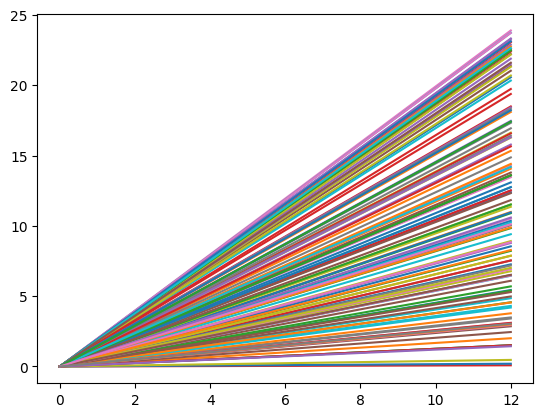

In [27]:
train_loader_iter=iter(train_loader)
X,Y=next(train_loader_iter)
X=X.numpy()
Y=Y.numpy()
print(train_x)
# plt.plot(Y[:,0],Y[:,1])

# plt.xlabel('Index of Energy grids')
# plt.ylabel('Intensity (a.u.)')
plt.figure()
for i in range(len(X)):
    plt.plot(train_x[0],X[i])
    # plt.plot(train_x[0],Y[i][0]*train_x[0],'--')

In [28]:
Y

array([[1.0328646 ],
       [0.9154323 ],
       [0.9082092 ],
       [1.1338979 ],
       [1.9065416 ],
       [0.50783235],
       [1.9909052 ],
       [0.6279766 ],
       [0.56450003],
       [1.9773962 ],
       [1.7138399 ],
       [1.1718922 ],
       [0.3804103 ],
       [0.62817323],
       [1.0431299 ],
       [1.7523142 ],
       [1.1825212 ],
       [0.29062426],
       [0.9597718 ],
       [0.40450445],
       [0.91260886],
       [0.65626067],
       [0.6850391 ],
       [1.0431299 ],
       [1.3149832 ],
       [1.7808979 ],
       [1.1215534 ],
       [0.8369111 ],
       [0.94608676],
       [0.3587813 ],
       [0.7118526 ],
       [1.2776047 ],
       [0.9597718 ],
       [1.5408841 ],
       [1.5344188 ],
       [0.41494253],
       [0.87671053],
       [1.4436187 ],
       [1.3853893 ],
       [0.12586093],
       [0.4529559 ],
       [1.508038  ],
       [0.8196649 ],
       [1.6146504 ],
       [1.4553756 ],
       [1.0269794 ],
       [1.9763807 ],
       [0.284

In [29]:

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)
checkpoint_callback = ModelCheckpoint(monitor="val_loss_epoch", mode="min")
#afunc:tanh,ReLU
net=Vani_NN(feature_len=100,label_len=1,config_para={"linear1":128,"linear2":64})
net.apply(init_weights)
model=NN_model_vani(net,nn.MSELoss(),lr=1e-1)
steps_per_epoch = int(2000/ 100)
logger=TensorBoardLogger('lightning_logs_all/new_3/',name="data_x")#'data_10152024_no_normalization'
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(max_epochs=200,limit_train_batches=steps_per_epoch,limit_val_batches=steps_per_epoch,logger=logger,callbacks=[checkpoint_callback,lr_monitor])#,pl.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, mode='min',verbose=False)#,callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, mode='min',verbose=False)]
trainer.fit(model, train_loader, val_loader)

D:\Users\Kaife\Temp\ipykernel_4540\1652012855.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 21.2 K
1 | loss       | MSELoss    | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
--------------------

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [27]:
from glob import glob
# with open("config/config-lxx5113w.yaml",'r') as file:
#     NN_config=yaml.safe_load(file)
# parameters={'output1':NN_config['output1']['value'],
#     'kernel1':NN_config['kernel1']['value'],
#     'dropout1':NN_config['dropout1']['value'],
#     'output2':NN_config['output2']['value'],
#     'kernel2':NN_config['kernel2']['value'],
#     'dropout2':NN_config['dropout2']['value'],
#     'output3':NN_config['output3']['value'],
#     'kernel3':NN_config['kernel3']['value'],
#     'dropout3':NN_config['dropout3']['value'],
#     'linear1':NN_config['l_nn']['value']
#     }
data_mod=DAR_data_Vani(data_path='dataset/',
        x_data_s_path='training_table.csv',
        y_data_s_path='training_label.csv',
        discriptor=["A","B","C"],
        batch=1000,
        normal_y=False,
        normal_x=False,
        Xscaling_method="maxabs",
        Yscaling_method="maxabs"
        )
data_mod.prepare_data_train()
data_mod.setup(stage='fit')
train_loader=data_mod.train_dataloader()
val_loader=data_mod.val_dataloader()

def load_from_checkpoint(model,path):
    checkpoint=torch.load(path)
    loaded_dict = checkpoint['state_dict']
    # n_clip = len(prefix)
    adapted_dict = {k: v for k, v in loaded_dict.items()}
    model.load_state_dict(adapted_dict)  



foldernames=glob('lightning_logs_all/new_3/data_x/*')[-1]#data_10152024_no_normalization
print(foldernames)
batch_size=data_mod.batch
data_mod.setup(stage='test')

net=Vani_NN(feature_len=100,label_len=3,config_para={"linear1":128,"linear2":64})
# net.apply(init_weights)
model=NN_model_vani(net,nn.MSELoss(),lr=1e-5)
filename=glob(foldernames+"/checkpoints/*.ckpt")[0]
print(filename)
load_from_checkpoint(model,filename)
model.to('cpu')
model.eval()

lightning_logs_all/new_3/data_x\version_8
lightning_logs_all/new_3/data_x\version_8/checkpoints\epoch=8-step=180.ckpt


NN_model_vani(
  (net): Vani_NN(
    (NN): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (loss): MSELoss()
  (train_loss): MeanMetric()
  (val_loss): MeanMetric()
)

In [28]:
test_x,test_y=data_mod.prepare_test_data()
# test_y=scaler.inverse_transform(test_y)
y_predict=model(test_x)
y_predict_test=y_predict.detach().numpy()
#y_predict_test_li.append(scaler.inverse_transform(y_predict_test))
# y_predict_test_li.append(y_predict_test)

In [29]:
test_y

tensor([[0.9461, 1.8776, 0.9967],
        [1.0963, 0.2975, 0.8628],
        [1.9243, 1.2062, 0.6383],
        ...,
        [0.9838, 1.5751, 0.7399],
        [1.8313, 0.0410, 0.7086],
        [1.5081, 1.6031, 0.7099]])

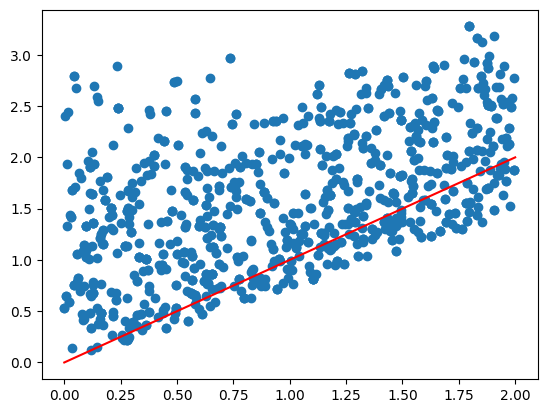

In [33]:
plt.figure()
plt.plot(test_y[:,1],y_predict_test[:,1],'o')
plt.plot([0,2],[0,2],'r-')

# wandb test

In [16]:
import wandb
wandb.login(key='ebdb46b0fb5d52411052955d3879ce00006895f1')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaifzheng. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kaife/.netrc


True

In [17]:
import math
import wandb
import toml
# sweep
sweep_config = {
    "method":'bayes',

}

metric = {
    'name':'val_loss_epoch',
    'goal':'minimize'
}

sweep_config['metric']=metric

parameters = {
     'batch_size':{
         'values':[2,4,8,16,32,64,128,256] 
         #'value':64
     },
    #  'delta':{
    #      'distribution':'uniform',
    #      'min':0.01,
    #      'max':1
    #  },
    # 'delta':{
    #     'value':0.2
    # },
    "layer1":{
        "values":[1,2,3,4,5,6,7,8,9,10,16,32,64,128]},
    "layer2":{
        "values":[1,2,3,4,5,6,7,8,9,10,16,32,64,128]
    },
    "lr":{
        "values":[1e-5,1e-4,1e-3,1e-2,1e-1,1.0,10.0]},

    #  'slope':{
    #      'distribution':'uniform',
    #      'min':0.01,
    #      'max':1
}
sweep_config['parameters']=parameters
toml.dump(sweep_config,open('tuning/sweep_config.toml','w'))
# toml.dump(parameters,open('tuning/sweep_parameters.toml','w'))

'method = "bayes"\n\n[metric]\nname = "val_loss_epoch"\ngoal = "minimize"\n\n[parameters.batch_size]\nvalues = [ 2, 4, 8, 16, 32, 64, 128, 256,]\n\n[parameters.layer1]\nvalues = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64, 128,]\n\n[parameters.layer2]\nvalues = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64, 128,]\n\n[parameters.lr]\nvalues = [ 1e-5, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,]\n'

In [18]:
config=toml.load(open('tuning/sweep_config.toml'))
config

{'method': 'bayes',
 'metric': {'name': 'val_loss_epoch', 'goal': 'minimize'},
 'parameters': {'batch_size': {'values': [2, 4, 8, 16, 32, 64, 128, 256]},
  'layer1': {'values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64, 128]},
  'layer2': {'values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 32, 64, 128]},
  'lr': {'values': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}}}

In [19]:
from pytorch_lightning.loggers import WandbLogger

In [20]:

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.1)
def train(config=None):
    with wandb.init(config=config):
        config=wandb.config
        wandb_logger=WandbLogger(name="data_x",project="DAR",log_model=True)
        parameters={
            'linear1':config.layer1,
            'linear2':config.layer2
        }
        data_mod=DAR_data_Vani(data_path='dataset/',
            x_data_s_path='training_table.csv',
            y_data_s_path='training_label.csv',
            discriptor=["A"],
            batch=config.batch_size,
            normal_y=False,
            normal_x=False,
            Xscaling_method="maxabs",
            Yscaling_method="maxabs"
            )

        data_mod.prepare_data_train()
        data_mod.setup(stage='fit')
        train_loader=data_mod.train_dataloader()
        val_loader=data_mod.val_dataloader()
        checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
        #afunc:tanh,ReLU
        net=Vani_NN(feature_len=100,label_len=1,config_para={"linear1":config.layer1,"linear2":config.layer2})
        net.apply(init_weights)
        model=NN_model_vani(net,nn.L1Loss(),lr=config.lr)
        steps_per_epoch = 100
        logger=TensorBoardLogger('lightning_logs_all/new_2/test',name="data_x")#'data_10152024_no_normalization'
        lr_monitor = LearningRateMonitor(logging_interval='epoch')
        trainer = pl.Trainer(max_epochs=30,
                             limit_train_batches=steps_per_epoch,
                             limit_val_batches=steps_per_epoch,
                             logger=wandb_logger,
                             callbacks=[checkpoint_callback,lr_monitor])#,pl.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, mode='min',verbose=False)#,callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=0.0001, mode='min',verbose=False)]
        trainer.fit(model, train_loader, val_loader)#logger=logger,

In [21]:
sweep_id = wandb.sweep(config,project="x_model")
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()
# torch.cuda.max_memory_allocated(device=None)
torch.cuda.memory_summary(device=0, abbreviated=False)

Create sweep with ID: zlkurntq
Sweep URL: https://wandb.ai/kaifzheng/x_model/sweeps/zlkurntq


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [ ]:
wandb.agent(sweep_id,train,count=500)

wandb: Agent Starting Run: fmeg07uo with config:
wandb: 	batch_size: 8
wandb: 	layer1: 10
wandb: 	layer2: 6
wandb: 	lr: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_f

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▆▄▅▅▃▅▃▄▂▃▅▄▄▅▁▂▆▄▅▇▇█▅▃▅▂▄▇▄
train_loss_step,▃▅▅▆▆▇▁▃▁▇▄▇▄▆▆▄▅▂▅▅▃▃▂█▆▅▂▂▅▆▇▅▅▄▃▇▄▆▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▆▇▁▄▂▂▅▂▃▄█▂▄▃▄▄▂▆▆▄▃▅▃▇▃▆▅▅▅
val_loss_step,▃▅▆▅▆▄▅▆▆▁█▃▆▃▆▆▇▆▄▁▁█▂▄▂▂▂▄▂▄▃▆▇▇▅▅▄▅▅▂
epoch,29
lr-Adam,1
train_loss_epoch,4.30716
train_loss_step,4.06718


wandb: Agent Starting Run: en3oa33c with config:
wandb: 	batch_size: 256
wandb: 	layer1: 9
wandb: 	layer2: 6
wandb: 	lr: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 976   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
976       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▄▄▅▅▄▃▅▇█▄▄▆▁▄▅▄▅▅▂▅▁▇▆▆▅▅▃▇▆▆
train_loss_step,▅▆▂▇▃▅▅▃▄▃▆▃▅▅▅▃▃▃▄▆▂▄▂▅▄▄▅▁▃▅▇▆▅▂▆▅▆█▃▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▄▇▄▅▇▃▆▅█▇▅▃▆▃▅▄▅▆▂▄▁▃▅▃▆▅▇▆▅▄
val_loss_step,▅▃▂▃▄▅▅▆▅▃▃▃▃▃▄▅▁▆▄▄▂▅▆▃▁▅▆▅▅▅▄▂▂▄▁▆▃█▃▆
epoch,29
lr-Adam,10
train_loss_epoch,0.60667
train_loss_step,0.62696


wandb: Agent Starting Run: p9e5r3p4 with config:
wandb: 	batch_size: 128
wandb: 	layer1: 16
wandb: 	layer2: 5
wandb: 	lr: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.7 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.7 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▄▂▃▄▇▅▇▆▄▁▅▅▄▆▅█▃▄▆▆▃▃▆▃▅▅▁▄▆▅
train_loss_step,▃▅▅▁▆▆▇▅▄▅▅▆▆▄▆▂▆▆▇▄▆▅▆▅██▄▅▅█▆▅█▄▇▆▅▇▇▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▄▆▄▆▅█▆▅▆▆▄▅▅▅▅▇▆▅▆▅▆▄▁▅▇▇▃▅▃▂
val_loss_step,▃▆▃▁▆▅▇▄▄▄▃▁▂▆█▇▇▅▇▄▆▆▄▆▃▆▅▃▆▄▆▆▂▇▅▃▄▂▃█
epoch,29
lr-Adam,10
train_loss_epoch,9.31281
train_loss_step,9.48183


wandb: Agent Starting Run: rur4muud with config:
wandb: 	batch_size: 128
wandb: 	layer1: 2
wandb: 	layer2: 1
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 207   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
207       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▆▅▁▇▃▄▅▄▄▃▃▆▃▆▄▄▃▂▆▇▄▇▄█▇▁▃▆▆▁
train_loss_step,▅█▄▅▂▁▇▅▄▁▂▅▃▄▅▁▆▆▄▅▅▂▃▁▃▅▅▄▆▃▃▆▄▃▅▅▂▄▇▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▅▃█▂▆▃▇▆▃▅▄▅▃▄▅▃▆▃█▅▆▅▆▁▄▆▆▃▅▃
val_loss_step,▄▁█▇▄▆▃▂▄▂█▅▁▅▃▄▃▆▃▄▂▄▅▅▁▁▂▄▇▆▆█▆█▆█▅▇▅▅
epoch,29
lr-Adam,1e-05
train_loss_epoch,15.44854
train_loss_step,14.25205


wandb: Agent Starting Run: 6n76vyxu with config:
wandb: 	batch_size: 128
wandb: 	layer1: 32
wandb: 	layer2: 16
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 3.8 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
3.8 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▅▄▄▄▄▃▄▃▁▃▄▆▅▅▃▃▃▅▁▂▅▆▃▃▂▃▃█▂▃
train_loss_step,▄▆▄▇▆▇▆▃▆▂▄▃▃▆▆▁▅▅▃▃▃▄▅▃▆▇▅▄▃▄▃▅▂▄▄▃▄█▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▆▂▁▁▂▄▃▃▅▅▇▃▆▂▄▅▁▄▄▄▅▃▃█▅▄▅▄▃▃
val_loss_step,▅▅▂▅▅█▁▆▅▁█▃▅▇▇▅▇▇▄▆▄▃▃█▃▄▂█▅▅▆▃▂▆▇▁▄▃▆▄
epoch,29
lr-Adam,1e-05
train_loss_epoch,9.87502
train_loss_step,9.54562


wandb: Agent Starting Run: u95uz4bg with config:
wandb: 	batch_size: 8
wandb: 	layer1: 16
wandb: 	layer2: 9
wandb: 	lr: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.8 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.8 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▂▂▂▄▅▂▂▁█▇█▇▅▁▂▅▅▁▅▇▄▇▃▇▃▅▄▄▆
train_loss_step,▂▆▃▁▄▃▆▇▄▄▅▆▅▆▅▇▅█▇▆▇▅▅▁▃▆▇▆▄▇▆▅█▅▆▅▃▅▃█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▅▅▅▄▃▃█▅▄▇▃▃▁▄▃▆▆▃▄▃▅▅▅▆▃▃▃▅▅
val_loss_step,▂▄▅▄▄▄▄▁▄▄▆▄▆▆▇▆▄▆▆▄▂▆▅▅▆▁▇▂▄██▆▅▅▆▆██▄▄
epoch,29
lr-Adam,0.0001
train_loss_epoch,10.03592
train_loss_step,12.90826


wandb: Agent Starting Run: l6wt5mvo with config:
wandb: 	batch_size: 16
wandb: 	layer1: 16
wandb: 	layer2: 16
wandb: 	lr: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.9 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.9 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▇█▆▁▅▄▅▆▄▇▃▄▇▇▄█▅▅▅▇▄▃▆▅█▆▃▆▇▅
train_loss_step,▆▄▃▃▆▄▅▃▅▆▅▅▄▅▅▄▃▅▅▃▂▇▃▅▆▇█▁▄▅▃▄▃▇▅▃▆▁▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▆▂▂▃▇▅▄▂▄▄▆▆▆▃▃▂▃▅▆▆▃▆▂▅▅▁▅▄█▆
val_loss_step,▃▆▃▅█▅▃▅▄▄▅▅▇▃▃▅▃▅▅▂▅▁▃▅▂▄▆▄▄▅▃▂▅▄▂▄▅▅▆▂
epoch,29
lr-Adam,0.0001
train_loss_epoch,5.77542
train_loss_step,5.60114


wandb: Agent Starting Run: 3dw5idvn with config:
wandb: 	batch_size: 2
wandb: 	layer1: 9
wandb: 	layer2: 3
wandb: 	lr: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 943   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
943       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▇▇▅▆▅▇▆▆▇▅▇▇▄▄▆▂▁▃▃▆▅▆▄▆▅▅▆▄█▄
train_loss_step,▅▇▄▅▂▅▆▄▇▃▅▇▅▅▇▅▄▆█▅▆▆▅▃▃▁▅▇▆▁▆▆▅▄▅▄▄▃▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▄▆▅▂▄▁▆▄█▁▄▅▅▅▄▇▁▆▃▂▃▇▄▅▅▂▁▁▄▃
val_loss_step,▁▆▁▃▅▁▆▆█▃▃▇▆▅▆▂▅▅▄▇▅▇██▃▁▃▃▅▆▅▇▅▇▄▄▂▅▂▃
epoch,29
lr-Adam,0.001
train_loss_epoch,0.23584
train_loss_step,0.20132


wandb: Agent Starting Run: j1myf7t1 with config:
wandb: 	batch_size: 32
wandb: 	layer1: 9
wandb: 	layer2: 128
wandb: 	lr: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 2.3 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
2.3 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▃▇▆▂▇▁▄▃▄▃▄▄▅▆▂▄▃▄▂▅▆▆▅▄▂▃▃█▆
train_loss_step,▅█▅▇▄▄▆▅▇▅▇▆▁▅▆▆▂▅▇▂▆▃▆▄▇▆▆▄▇▂▃▄▃▂▃▃▅▅▇▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▂▃▃▄▄▅▅▄▄█▅▂▃▆▄▅▁▆▄▂▅▄▃▁▃▄▄▂▄▄
val_loss_step,▁▃▃▇▄▅▄▄▄▃▃▂▃█▄▄▃▃▂▅▄▅▃▁▅▆▄▆▂▁▃▃▅▃▃▆▄▃▄▅
epoch,29
lr-Adam,10
train_loss_epoch,6.01962
train_loss_step,5.90541


wandb: Agent Starting Run: 19fsx3rb with config:
wandb: 	batch_size: 128
wandb: 	layer1: 6
wandb: 	layer2: 8
wandb: 	lr: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 671   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
671       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▃▇▄▅▂▃▄▂▅▆▄▃▄▂▄▄█▅▄▂▅▁▃▅▅▄▅▄▄
train_loss_step,▅▅▂▃▆▆▇▆▅▃▄▄▃▅▆▅▇▄▇▁▄▄▅█▆▆▄▆▃▁▁▃▆▅▄▆█▅▆▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▅▃▅▅▄▃▂▄▆▄▆█▃▃▆▅▆▄▃▃▂▄▆▇▅▁▆▃▇▃
val_loss_step,▃▅▆▃▅▃▇▅▄▆▄▇▆▃█▇▃▃▅▅▃▅▇█▇▃▄▄▄▅▅█▄▆▁▄▃▇▂▅
epoch,29
lr-Adam,0.1
train_loss_epoch,0.30168
train_loss_step,0.30511


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: me2pmj2z with config:
wandb: 	batch_size: 256
wandb: 	layer1: 9
wandb: 	layer2: 5
wandb: 	lr: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 965   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
965       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▄▄▄▅▆▁█▄▂▅▃▄▃▃▇▄▁▅▅▂▂▃▄▇▂▅▁▂▄▄
train_loss_step,▅▂▆▆▅▄▄▄▃▄█▃▃▁▆▅▄▇▄▇▂▅▄▇▇▄▄▄▄▂▃▅▃▃▆▄▂▅▃▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▅▇▄▃▄▆▅█▂▆▂▅▆▅▆▅▅▅▆▅▅▁▃▄▃▅▄▅▅▅
val_loss_step,▃▂▃▅▅▂▄▅▅▅▅▆▄▇▆▅▄▃▆▂█▄▃▆▆▇▃▄▄▂▅▄▃▄▆▁▅▆▅▄
epoch,29
lr-Adam,1
train_loss_epoch,17.13971
train_loss_step,17.72231


wandb: Agent Starting Run: 9oij18j7 with config:
wandb: 	batch_size: 2
wandb: 	layer1: 9
wandb: 	layer2: 16
wandb: 	lr: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.1 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.1 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▇▅▅▂▅▄▄▄▆▆▅▄▇▇▆▄▆▄▇▃▆▁▇▅▆▅▇▅▃
train_loss_step,▅▁▃█▂▂▇▂▃▅▂▃▄▃▇█▅▃▃▃▄▆▂▂▄▇▁▂▆▃▄▆▅▆▇▃▅▄▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▇█▄▄▇▅▂▄▃▄▇▄▄▃▅▆▅▅▄█▅▇▅▆▄▇▇▄▁▄
val_loss_step,▄▃▅▅▃▇▆▃▅▇▄▃▇▃▅▄█▁▃▄▃▃▆▇▄▆▆▂▂▃▇▃▃▂▂▇▅▅▁▆
epoch,29
lr-Adam,0.001
train_loss_epoch,6.07314
train_loss_step,4.49937


wandb: Agent Starting Run: r4dujc2x with config:
wandb: 	batch_size: 2
wandb: 	layer1: 4
wandb: 	layer2: 7
wandb: 	lr: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 447   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
447       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▆▆▂▅▆██▃▆▁▅▅▆▃▄▄▅▂▇▃▅▆▅▅▅▆▅▄▅
train_loss_step,▅▆█▅▃▃▂▇▄▃▅▁▃▇▃▇▄▄▆▄█▅▄▄▆▃▃▄█▆▂▆▅▇▇▇▅▇▅▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▅▃▄▄▃▄█▄▇▆▇▆▆▄▆▇▄▁▅▂▇▅▅▆▄▃▆▇▆
val_loss_step,▄▄▃▅▅▄▆▅▆▅▄▆▃▇▄▆▄▇█▆▇▄▅▁▃▅▁▂▄▄▄▅▃▃▃▅▆▅▃▄
epoch,29
lr-Adam,0.1
train_loss_epoch,13.21893
train_loss_step,19.09606


wandb: Agent Starting Run: dozpisue with config:
wandb: 	batch_size: 64
wandb: 	layer1: 16
wandb: 	layer2: 9
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.8 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.8 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▅▁▄▂▄▃▆▇▄▆▆█▅▃▄▅▆▅▄▅▆▂▄▃▃▅▂▄▁▃
train_loss_step,▆▁▃█▅▅█▅▃▅▆▅▃▆▆▅█▄▄▄▃▄▆▄▆▆▇▃▂▄▄▅▄▆▃▄▆▆▆▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▂▂▆▄█▅▂▃▂▅▄▂▆▃▄▅▂▁▆▃▄▅▅▂▆▃▄▃▃
val_loss_step,▄▂▇▆▄▃▁▅█▅▆▃▆▅▅▃▅▅▄▅▄▄▅▇▅▆▇▅▅▇▅▄▅▃▆▅▂▇▅▇
epoch,29
lr-Adam,1e-05
train_loss_epoch,6.39092
train_loss_step,6.54462


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hd2ckpl9 with config:
wandb: 	batch_size: 64
wandb: 	layer1: 16
wandb: 	layer2: 128
wandb: 	lr: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 3.9 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
3.9 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▄▆▅█▁▄▃▆▄▁▃▄▆▁█▆▃▃▇▅▅▅▁▃▂▂▄▅▄
train_loss_step,▆▅▂▄▆▁▅▇▆▇▇▆▇▆▆▆▄▅▄▄▇▄▂▄▆▆▇▆▄▄▄▄▇▅█▆▇▃▆▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▆▃▅▁█▆▇▅▅▃▅▅▄▅▄▇▄▆▄▄▄▃▅▁▆▃▄▄▅
val_loss_step,▂▃▃▇▄▃██▆▃▂▁▁▁▃▃▅▇▁▂▅▃▅▄▃▁▂▇█▅▅▃▂▄▅▅▄▄▃▂
epoch,29
lr-Adam,1
train_loss_epoch,0.81548
train_loss_step,0.80685


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9sjpcgf3 with config:
wandb: 	batch_size: 4
wandb: 	layer1: 128
wandb: 	layer2: 7
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 13.8 K
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
13.8 K    Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▆▄▃▃▄▄▂▂▄▄▃█▁▆▃▃▂▃▅▃▇▂▂▄▁▃▄▅▄▅
train_loss_step,▆▄▆▇▄▄▄▄▅▅▆▃▇▄▃▃▆█▆█▇▂▆▄▄▆▃▄▃▂▆▃▂▂▅▄▇▁▃▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▆▄▂▃▂▅▄▆▇▆▇▆▁▄▆▃▆█▅▄▄▂▅▃▂▂▅▄▄▃
val_loss_step,▃▅▆▅▅▄▂▆▅▄▄▄▃▆▄▄▄▇▃▄▇▆▃▆▆▆▄▅▄▇█▃▄▃▁▆▇▄▆▃
epoch,29
lr-Adam,1e-05
train_loss_epoch,4.62402
train_loss_step,4.48133


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kgbuor30 with config:
wandb: 	batch_size: 256
wandb: 	layer1: 1
wandb: 	layer2: 128
wandb: 	lr: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 486   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
486       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▆▄▆▁▅▄█▄▆▃▂▅▄▂▄▃▆▄▆▅▅▅▆▃▁▅█▃▃
train_loss_step,▃▆▅█▁▅▅▅▄▄▅▆▄▆▇▅█▇▃▅▆▆▅▇▅▅▆▆▅▇█▅▆▄▅▅▅▄▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▁▄▅▅▃▃▆▃▅▂█▃▃▁▅▄▃▄▅▆▂▅█▂▄▇▄▂▃▃
val_loss_step,▇▄▅▆▄▄▄▆▁▄▆▄▅▄▆▅▅▃▄█▄▆▅▄▇▄▇▃▅▄▅▃▃▄▇▃▄▃▂▅
epoch,29
lr-Adam,1
train_loss_epoch,1.35592
train_loss_step,1.3057


wandb: Agent Starting Run: fpozhq9z with config:
wandb: 	batch_size: 8
wandb: 	layer1: 16
wandb: 	layer2: 128
wandb: 	lr: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 3.9 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
3.9 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▆▃▅▇▆▆▁▃▅▆▆▅▃▆▃▇▅▅▄▄█▆▂▅▆▃▄▆▅▂
train_loss_step,▄▄▄▄▂▅▄▅▄▂▂▄▄▄▆█▆▃▃▃▆▃▂▇▅▂▄▃▄▃▅▄▂▆▁▅▃▄▇▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▁▄▄▃▄▁▄▃▅▁▃▃▆▆▃▃▅▃▄▃▅▂▄▄█▇▂▃▄▂
val_loss_step,▆▅▅▆▇▁▆▅▅▇▂▅▆▄▂▃▁█▂▇▇▄▆█▆▃▂▃▁▃▇▄▃▅▅▅▅▄▄▇
epoch,29
lr-Adam,0.1
train_loss_epoch,2.88218
train_loss_step,3.01915


wandb: Agent Starting Run: dcg5t9al with config:
wandb: 	batch_size: 8
wandb: 	layer1: 7
wandb: 	layer2: 3
wandb: 	lr: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 735   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
735       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▅▃▆▄▄▅▄▄▃▅▂▁▃▁▆▅▆▁▅▅▄▅▄▇▄█▃▅▄▄
train_loss_step,▂▇▅▁▆▃▂▁█▂▆▃▇▅▄▂▅▄▃▆▇▄▂▅▃▇▄▂▅▅▄▂▆▄▅▇▁██▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▅▄█▃▅▆▆▆▄▂▃▄▅▆▆▄▄▆▃▅▃▅▄▃▅▃▅▃▁▅
val_loss_step,▄▄▄█▄▆▆▆▄▄▆▄▅▂▅▅▄▁▄▃▃▅▅▅▃▅▂▆▄▃▄▄▃▄▃▆▅▂▁▃
epoch,29
lr-Adam,0.0001
train_loss_epoch,0.28403
train_loss_step,0.30185


wandb: Agent Starting Run: uyk9jge1 with config:
wandb: 	batch_size: 16
wandb: 	layer1: 8
wandb: 	layer2: 9
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 899   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
899       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▂▆▆▂▂▆▁█▃▆▅▄▃▅▄▃▅▂▃▅▅▃▄▁▂▅▃▅▃
train_loss_step,▄▅▃▃▅▅▃▄▅▄▁▁▅▄▄▇▄▄▆▃▂▃▅▅▇▇▅▃▄▄▂▃▆▃▆▅▆▂▆█
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▂▅▄▃▁▃▄▂▃▄▆▄▄▆▄▆█▄▃▆▆▅▅▃▃▁▄▅▆▆
val_loss_step,█▃▂▃▃▇▆▄▇▇▄█▇▇▅▅▆▆▇▅▅▄▇▄▄▇▆▄▂▇▆█▇█▆▁▅█▆▅
epoch,29
lr-Adam,1e-05
train_loss_epoch,1.78948
train_loss_step,2.35847


wandb: Agent Starting Run: 556od1p1 with config:
wandb: 	batch_size: 4
wandb: 	layer1: 5
wandb: 	layer2: 6
wandb: 	lr: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 548   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
548       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▆▂██▇▅▂▅▆█▁▄▅▇▄▅▅▄▁▂▄▃▆▇▄▄▇▂▂
train_loss_step,▇▂█▃▅▇▄▁▃▅▇▆▆▅▄▄▄▂▄▃▄▅▆▄▅▃▂▄▃▄▄▆▂▅▃▂▆▄▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▁▄▄▆▄▅▆▂▂▇▄▅▅▅▃▆█▄▃▃▄▇▅▃▃▄█▃▆▄
val_loss_step,▅▃▁▃█▅▂▃▁▄▃▂▅▄▂▁▃▄▂▅▃▆▂▃▂▁▄▃▁▄▄▄▄▃▁▂▄▃▃▄
epoch,29
lr-Adam,0.001
train_loss_epoch,5.98936
train_loss_step,5.22488


wandb: Agent Starting Run: gbvfkq9c with config:
wandb: 	batch_size: 64
wandb: 	layer1: 16
wandb: 	layer2: 1
wandb: 	lr: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.6 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.6 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▆▄▅▅▆▅▅█▅▅▄▆▁▄▄▅▅▅▂▅▄▄▅▅▃▆▆▃▅
train_loss_step,▄▃▇▃▃▅▁▇▆▆▅▃▄▅▃▄▅▃▅▃▇▂▅▂▅▃▃▆▂▅▄▅▅▅▃▃█▅▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▅▃▃▅▄▄▃▁▃▄▂▄▄▄▄▁▂▃▅▄█▅▂▄▂▃▃▃▁
val_loss_step,▂▃▅▇▅▄▂▅▇▆▂▄▄▇▃▅▅▃▃▆▆▄▃▄▃▆▇▄▄▇▄▅▁▂▁▅▅▄▄█
epoch,29
lr-Adam,0.1
train_loss_epoch,8.58786
train_loss_step,8.59485


wandb: Agent Starting Run: iuofgmr7 with config:
wandb: 	batch_size: 128
wandb: 	layer1: 2
wandb: 	layer2: 128
wandb: 	lr: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 715   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
715       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▅▄▇▄▁▂▇▁▇██▅▃▅▆▂▂█▅▅▄▃▆▄▃▄▅▄▃▇
train_loss_step,▅▃▅▆▆▅█▁▇▅▄▇▇█▄▃▆▅▇▅▄▅▃▅▄▃▄▇▃▆▅▅▅▅▅▄▆▆▇▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▆▁▆▃▅▄▃▇▃▂▃▅▆▃▃▅▅█▅▃▃▄▆▅▇▅█▅▆▁
val_loss_step,▆▄▃▅▃▆█▁▄▅▄▅▅▂▅▆▅▁▄▃▅▂▄▇▆▅▇▄▃▆▄▃▄▃▃▃▄▇█▆
epoch,29
lr-Adam,0.001
train_loss_epoch,0.21605
train_loss_step,0.21529


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ykn4p62f with config:
wandb: 	batch_size: 128
wandb: 	layer1: 2
wandb: 	layer2: 9
wandb: 	lr: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 239   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
239       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▇▅▅▇▆▄▅▆▅▁▇▅█▅▅▇▃█▆█▆▄▇█▄▅▅▃▅█
train_loss_step,█▂▂▄▆▄▃▆▃▃█▂▄▇▄▅▆▃▅▅▇▇▅▄▅▅▅▄█▃▄▅▂▂▃▂▁▄▄▆
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▄▄▃▄▃▅▇▆▅▆▇▅▆▄▄▇▆▆▄▆▃▄▅█▇▃▅▁▃▆
val_loss_step,▄▃▅▄▃▄▁▆▃▅▄▃▄▄▄▂▂▆▃█▇▁▆▃▅▂▆▂▆▅▇▇▂▂▃▁▂▃▅▅
epoch,29
lr-Adam,0.01
train_loss_epoch,0.16141
train_loss_step,0.16698


wandb: Agent Starting Run: x2acxq3z with config:
wandb: 	batch_size: 128
wandb: 	layer1: 1
wandb: 	layer2: 1
wandb: 	lr: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 105   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
105       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▂▄▄▇▃▅▄▅▃▆▅▅▄▃▄▄▄▃▆▃▁▂▅▅▁█▆▇▆▆
train_loss_step,▃▄▆▆▄▄▅▂▁▅▆▆▅▆▇▆▅█▆▄▆▇▄▅▄▄▆▄▆▇▅▆▃▆▂▆▅▄▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▅▆▆▄▅▅█▄▇▃▇▃▅▅▆▅▅▅▇▂▃▅▄▃▁▁▂▅▄▅
val_loss_step,▃▅▄▅▂▃▇▂▆▃█▃▁▄▃▄▇▄▂▆▂▆▃▃▃▂▅▃▃▂▂▅▅▂▂▅▇▇▅▂
epoch,29
lr-Adam,0.0001
train_loss_epoch,0.9188
train_loss_step,0.92549


wandb: Agent Starting Run: xo1vg6kh with config:
wandb: 	batch_size: 256
wandb: 	layer1: 2
wandb: 	layer2: 6
wandb: 	lr: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 227   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
227       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▃▆▅▅▇▅▄▄▃▅▅▃▅▃▂▄▁▆▆▆█▃▇▃▄█▃▃▅
train_loss_step,▄▆▃▃▅▆▅▅▁▅▄▄▂▂▅▇▂▆▃▅▂▃█▄▃▅▄▅▅▆▄▅▅▃▃▅▁▃▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▃▇▆▃▂▁▃▅█▄▂▅▄▇█▃▆▆▂▅█▇▁▂▇▇▃▆▄▄
val_loss_step,▃▄▄▃▅▂▅▃▁▇▆▄▃▄▅▃▃▆▅▄▂▄▃▆▇▃▅▇█▆▄▃▃▅▆█▄▅▃▂
epoch,29
lr-Adam,0.0001
train_loss_epoch,12.06131
train_loss_step,11.89017


wandb: Agent Starting Run: hnri0von with config:
wandb: 	batch_size: 8
wandb: 	layer1: 4
wandb: 	layer2: 4
wandb: 	lr: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 429   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
429       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▄▄▄▅█▃▅█▆▃▆▃▄▁▃▅▆▅▇▆▆▅▄▆█▇▃▂█▆
train_loss_step,▅▂▄▅▅▆▆▆▆▅▁▃█▇▅▆▆▄▃▅▇▄▄▅▇▃▅▅▆█▅▆▅▇▄▄▃▃▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▇▃▆▅▆▅▃▇█▅▆▇▄▇▄▇▇▆▃▅▇▅▇▅▆▇▃▁▇█
val_loss_step,▆▃▅█▃▂▅▂▂▅▄▅▃▄▃▃▅▅▄▃▅▆▃▅▃▄▅▇▂▃▃▅▃▃▅▃▁▃▁▃
epoch,29
lr-Adam,0.1
train_loss_epoch,1.73795
train_loss_step,1.1818


wandb: Agent Starting Run: 7rd2o554 with config:
wandb: 	batch_size: 128
wandb: 	layer1: 8
wandb: 	layer2: 8
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 889   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
889       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▃▅▄▄▂▅▅▃▄▃▃▁█▄▃▁▆▃▅▄▄▄▄▃▃▁▃▃▃▆
train_loss_step,▄▂▃▅▅▅▇▇▆▁▂▄▂▃▁▄▇▃▄▅█▅▃▆▅▃▅▆▂▃▅▄▅▃▇▇▆▇▆▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▅▆▅▅▇▅▆▆▅▄▆▇█▄▆▆▁▆▆█▄▆▅▆▅▃▅▃▆▃
val_loss_step,▃▂▅▄▂▂▄▄▃▂▄▄▁▅▅▃▃▄▁▅▂▃▄▄█▃▃▄▁▄▅▃▃▅▅▃▄▅▂▄
epoch,29
lr-Adam,1e-05
train_loss_epoch,0.53209
train_loss_step,0.53662


wandb: Agent Starting Run: tdtazoos with config:
wandb: 	batch_size: 256
wandb: 	layer1: 10
wandb: 	layer2: 1
wandb: 	lr: 1e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 1.0 K 
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
1.0 K     Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,▄▅▃▅▆▆▅▇▆▅▃▆▅▄▆▆▃▃▄▅▁▁█▄▂▅▁▄█▄
train_loss_step,▃▄▂▂▃▅▄▄▄▄▃▅▄▅▄▄█▂▅▄▃▃▄▂▇▃▅▄▁▂▇▁▂▆▂▃▃▂▄▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss_epoch,▆▇▅▅▆▂█▄▂▅▇▆▁█▄▂▄▆▂▆▄▇▅▅▃▅▆▅█▂
val_loss_step,▃▄▄▅▅▄▆▅▅▅▆▂▅▁▅▃▅█▄█▅▄▃▅▆▆▃▃▂▅▂▆▃▇▅▄▅▆▄▄
epoch,29
lr-Adam,1e-05
train_loss_epoch,4.63065
train_loss_step,4.72114


wandb: Agent Starting Run: mvinhe01 with config:
wandb: 	batch_size: 32
wandb: 	layer1: 3
wandb: 	layer2: 10
wandb: 	lr: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


c:\Users\kaife\anaconda3\envs\NN_work\lib\site-packages\pytorch_lightning\loggers\wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
D:\Users\Kaife\Temp\ipykernel_836\1688199199.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Vani_NN    | 354   
1 | loss       | L1Loss     | 0     
2 | train_loss | MeanMetric | 0     
3 | val_loss   | MeanMetric | 0     
------------------------------------------
354       Trainable params
0       

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]